In [9]:
df <- read.csv(file = 'jdp_views_test.csv')
head(df)

,jdp_visits,user_token
,<int>,<chr>
1,0,js_1814393
2,3,js_658987
3,0,js_534686
4,2,js_332088
5,5,js_313533
6,1,js_206410


In [1]:
## Using mixture models for clustering in the iris dataset
## Compare k-means clustering and a location and scale mixture model with K normals

### Loading data and setting up global variables
rm(list=ls())

In [3]:
install.packages("mclust")
install.packages("mvtnorm")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
library(mclust)
library(mvtnorm)

Package 'mclust' version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘mvtnorm’


The following object is masked from ‘package:mclust’:

    dmvnorm




[1] "ss = 1"
[1] "ss = 2"
[1] "ss = 3"
[1] "ss = 4"
[1] "ss = 5"
[1] "ss = 6"
[1] "ss = 7"
[1] "ss = 8"
[1] "ss = 9"
[1] "ss = 10"
[1] "ss = 11"
[1] "ss = 12"
[1] "ss = 13"
[1] "ss = 14"
[1] "ss = 15"


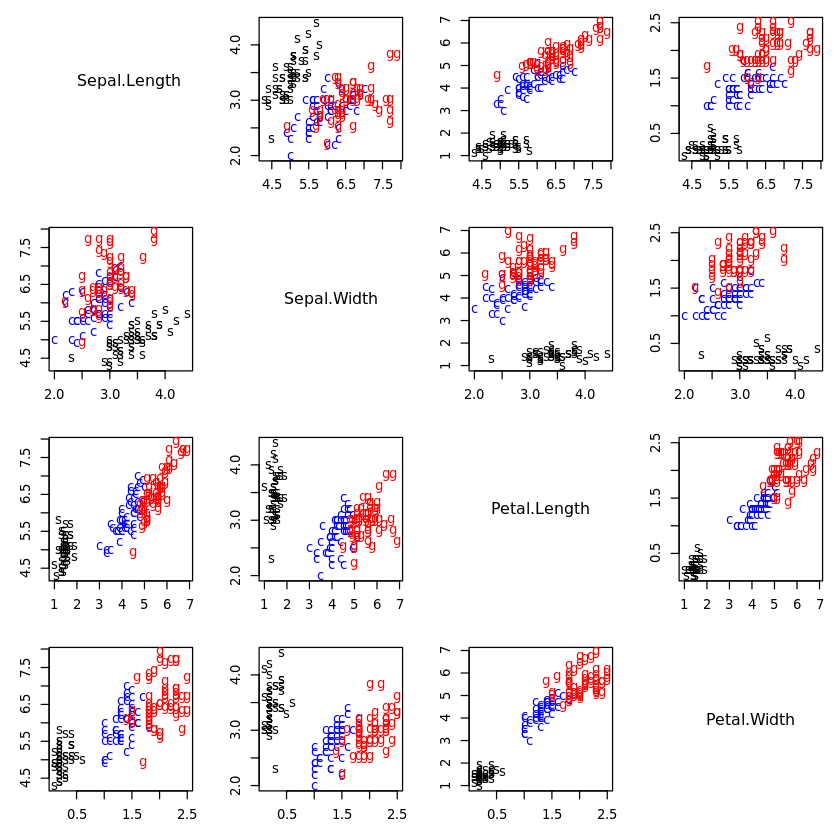

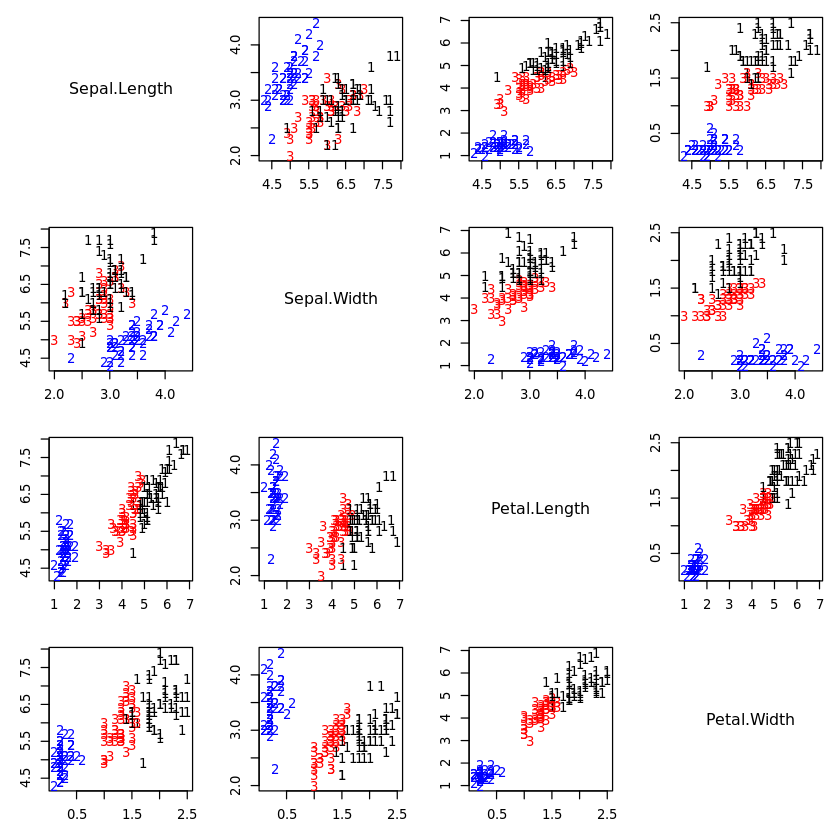

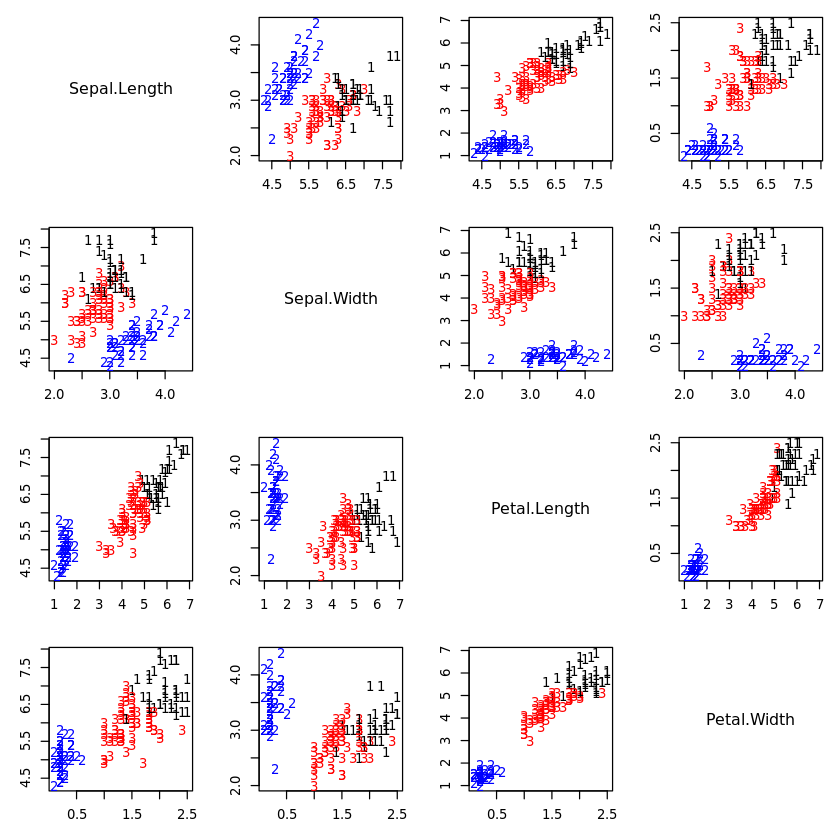

In [6]:
### Defining a custom function to create pair plots
### This is an alternative to the R function pairs() that allows for 
### more flexibility. In particular, it allows us to use text to label 
### the points
pairs2 = function(x, col="black", pch=16, labels=NULL, names = colnames(x)){
  n = dim(x)[1]
  p = dim(x)[2]
  par(mfrow=c(p,p))
  for(k in 1:p){
    for(l in 1:p){
      if(k!=l){
        par(mar=c(3,3,1,1)+0.1)
        plot(x[,k], x[,l], type="n", xlab="", ylab="")
        if(is.null(labels)){
          points(x[,k], x[,l], pch=pch, col=col)
        }else{
          text(x[,k], x[,l], labels=labels, col=col)
        }
      }else{
        plot(seq(0,5), seq(0,5), type="n", xlab="", ylab="", axes=FALSE)
        text(2.5,2.5,names[k], cex=1.2)
      }
    }
  }
}

## Setup data
data(iris)
x       = as.matrix(iris[,-5])
n       = dim(x)[1]
p       = dim(x)[2]       # Number of features
KK      = 3
epsilon = 0.0000001
par(mfrow=c(1,1))
par(mar=c(4,4,1,1))
colscale = c("black","blue","red")
shortnam  = c("s","c","g")
pairs2(x, col=colscale[iris[,5]], labels=shortnam[as.numeric(iris[,5])])


# Initialize the parameters of the algorithm
set.seed(63252)
numruns = 15
v.sum   = array(0, dim=c(numruns, n, KK))
QQ.sum  = rep(0, numruns)

for(ss in 1:numruns){
  w   = rep(1,KK)/KK  #Assign equal weight to each component to start with
  mu  = rmvnorm(KK, apply(x,2,mean), 3*var(x))   #Cluster centers randomly spread over the support of the data
  Sigma      = array(0, dim=c(KK,p,p))  #Initial variances are assumed to be the same
  Sigma[1,,] = var(x)
  Sigma[2,,] = var(x)
  Sigma[3,,] = var(x)
  
  sw     = FALSE
  QQ     = -Inf
  QQ.out = NULL
  s      = 0
  
  while(!sw){
    ## E step
    v = array(0, dim=c(n,KK))
    for(k in 1:KK){  #Compute the log of the weights
      v[,k] = log(w[k]) + mvtnorm::dmvnorm(x, mu[k,], Sigma[k,,], log=TRUE) 
    }
    for(i in 1:n){
      v[i,] = exp(v[i,] - max(v[i,]))/sum(exp(v[i,] - max(v[i,])))  #Go from logs to actual weights in a numerically stable manner
    }
    
    ## M step
    w = apply(v,2,mean)
    mu = matrix(0, nrow=KK, ncol=p)
    for(k in 1:KK){
      for(i in 1:n){
        mu[k,]    = mu[k,] + v[i,k]*x[i,]
      }
      mu[k,] = mu[k,]/sum(v[,k])
    }
    Sigma = array(0,dim=c(KK, p, p))
    for(k in 1:KK){
      for(i in 1:n){
        Sigma[k,,] = Sigma[k,,] + v[i,k]*(x[i,] - mu[k,])%*%t(x[i,] - mu[k,])
      }
      Sigma[k,,] = Sigma[k,,]/sum(v[,k])
    }
    
    ##Check convergence
    QQn = 0
    for(i in 1:n){
      for(k in 1:KK){
        QQn = QQn + v[i,k]*(log(w[k]) + mvtnorm::dmvnorm(x[i,],mu[k,],Sigma[k,,],log=TRUE))
      }
    }
    if(abs(QQn-QQ)/abs(QQn)<epsilon){
      sw=TRUE
    }
    QQ = QQn
    QQ.out = c(QQ.out, QQ)
    s = s + 1
  }
  
  v.sum[ss,,] = v
  QQ.sum[ss]  = QQ.out[s]
  print(paste("ss =", ss))
}

## Cluster reconstruction under the mixture model
cc = apply(v.sum[which.max(QQ.sum),,], 1 ,which.max)
colscale = c("black","blue","red")
pairs2(x, col=colscale[cc], labels=cc)
ARImle = adjustedRandIndex(cc, as.numeric(iris[,5]))  # Higher values indicate larger agreement

## Cluster reconstruction under the K-means algorithm
irisCluster <- kmeans(x, 3, nstart = numruns)
colscale = c("black","blue","red")
pairs2(x, col=colscale[irisCluster$cluster], labels=irisCluster$cluster)
ARIkmeans = adjustedRandIndex(irisCluster$cluster, as.numeric(iris[,5]))



In [8]:
# Load required libraries
library(MASS)
library(MCMCpack)

# Load the data
data(faithful)
x  = faithful$eruptions  # Duration of eruptions
n  = length(x)

# Number of components
KK = 2

# Initialize parameters
w     = rep(1 / KK, KK)  # Mixing weights
mu    = rnorm(KK, mean(x), sd(x))  # Component means
sigma = rep(sd(x) / sqrt(KK), KK)  # Component standard deviations
cc    = sample(1:KK, n, replace=TRUE, prob=w)  # Component assignments

# Set prior parameters using an empirical Bayes approach
eta = mean(x)
tau = sqrt(var(x))
aa  = rep(1, KK)
dd  = 2
qq  = var(x) / KK

# Number of MCMC iterations and burn-in
rrr  = 12000
burn = 2000

# Initialize storage for MCMC samples
w.out     = matrix(0, rrr, KK)
mu.out    = matrix(0, rrr, KK)
sigma.out = matrix(0, rrr, KK)

# Run the MCMC
for(s in 1:rrr) {
  
  # Sample component assignments (cc)
  for(i in 1:n) {
    probs = rep(0, KK)
    for(k in 1:KK) {
      probs[k] = log(w[k]) + dnorm(x[i], mu[k], sigma[k], log=TRUE)
    }
    cc[i] = sample(1:KK, 1, prob=exp(probs - max(probs)))
  }
  
  # Sample mixing weights (w)
  w = rdirichlet(1, aa + table(cc, nbins=KK))
  
  # Sample component means (mu)
  for(k in 1:KK) {
    xk = x[cc == k]
    nk = length(xk)
    mu_post = (sum(xk) + eta / tau^2) / (nk + 1 / tau^2)
    tau_post = sqrt(1 / (nk + 1 / tau^2))
    mu[k] = rnorm(1, mu_post, tau_post)
  }
  
  # Sample component standard deviations (sigma)
  for(k in 1:KK) {
    xk = x[cc == k]
    nk = length(xk)
    shape_post = dd + nk / 2
    rate_post = dd * qq + sum((xk - mu[k])^2) / 2
    sigma[k] = sqrt(1 / rgamma(1, shape_post, rate=rate_post))
  }
  
  # Store MCMC samples
  w.out[s, ] = w
  mu.out[s, ] = mu
  sigma.out[s, ] = sigma
}

# Compute posterior density estimates
xx = seq(0, 7, length=150)
density_post = matrix(0, nrow=rrr - burn, ncol=length(xx))
for(s in (burn + 1):rrr) {
  for(k in 1:KK) {
    density_post[s - burn, ] = density_post[s - burn, ] + w.out[s, k] * dnorm(xx, mu.out[s, k], sigma.out[s, k])
  }
}

# Compute the mean posterior density estimate
density_mean = rowMeans(density_post)

# Plot the density estimates
plot(density(x, from=0, to=7), main="Bayesian Density Estimation for Old Faithful Eruptions")
lines(xx, density_mean, col='red', lwd=2)
legend("topright", legend=c("Kernel Density", "MCMC"),
       col=c("black", "red"), lty=1, cex=0.8)


Loading required package: coda

##
## Markov Chain Monte Carlo Package (MCMCpack)

## Copyright (C) 2003-2023 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park

##
## Support provided by the U.S. National Science Foundation

## (Grants SES-0350646 and SES-0350613)
##



ERROR: Error in table(cc, nbins = KK): all arguments must have the same length
